In [12]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# two levels up from the notebook to project root, then append to sys.path
sys.path.append(str(Path().resolve().parents[1]))

PROJECT_ROOT = Path().resolve().parents[1]
RESULTS_PATH = PROJECT_ROOT / "results"


from utils.data_loading import load_datasets
from utils.data_preparation import get_spo2_to_po2_interpolator, add_shift_raw_column, add_engineered_features
from utils.evaluation import evaluate_macro_patient_level, print_evaluation, bland_altman_plots, bland_altman_pct_comparison
from utils.modeling import fit_cv_models, predict_cv_ensemble, average_linear_coeffs
from utils.logging import log_run_json


train_df, test_df, val_df, odc = load_datasets()
spo2_to_po2 = get_spo2_to_po2_interpolator(odc)



# Add raw shift column
train_df = add_shift_raw_column(train_df, spo2_to_po2)
test_df = add_shift_raw_column(test_df, spo2_to_po2)
val_df = add_shift_raw_column(val_df, spo2_to_po2)


In [20]:
full = pd.concat([train_df, test_df], ignore_index=True)

# Step 1: Compute mean shift_raw per patient
agg_shift_raw = full.groupby("Anon.Patient_ID")["shift_raw"].mean()

# Step 2: Extract true shift per patient (assumes same shift value across rows for each patient)
shift_true_per_patient = full.groupby("Anon.Patient_ID")["shift"].first()

# Step 3: Combine into one DataFrame
full = pd.concat([agg_shift_raw, shift_true_per_patient], axis=1).dropna()




In [21]:
desc = full["shift_raw"].describe(percentiles=[.25, .5, .75])
desc


count    219.000000
mean      12.289680
std        4.987076
min        4.642577
25%        9.409888
50%       10.907086
75%       12.995962
max       37.639606
Name: shift_raw, dtype: float64

In [32]:
desc_both = full[["shift_raw", "shift"]].describe(percentiles=[.25, .5, .75]).round(3)
desc_both.to_csv(RESULTS_PATH / "eda" / "shift_raw_shift_summary_statistics.csv")

In [22]:
from scipy.stats import skew
skew(full["shift_raw"].dropna())


2.1444717065399126

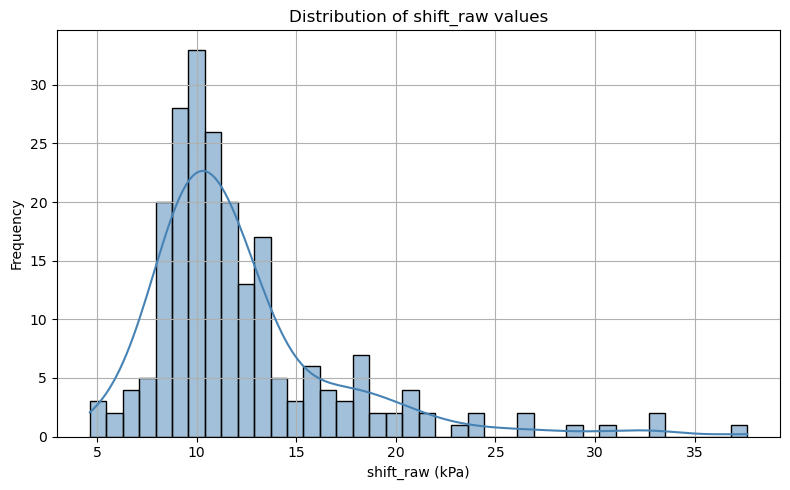

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.histplot(full["shift_raw"], bins=40, kde=True, color='steelblue')
plt.title("Distribution of shift_raw values")
plt.xlabel("shift_raw (kPa)")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()


In [24]:
# Assuming the true shift is in a column called 'shift'
corr = full[["shift_raw", "shift"]].corr().iloc[0, 1]
print(f"Pearson correlation: {corr:.3f}")


Pearson correlation: 0.948


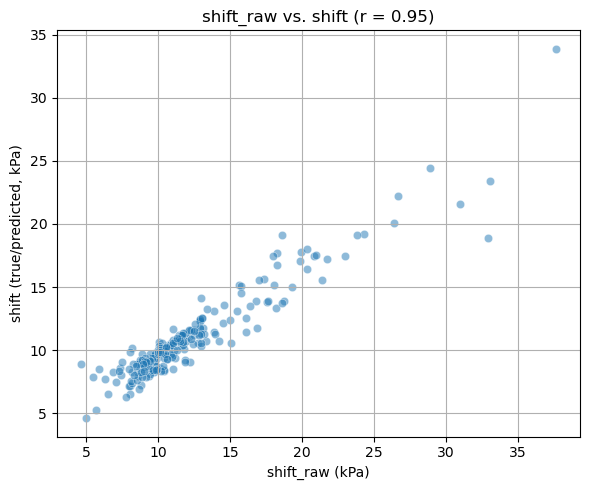

In [25]:
plt.figure(figsize=(6, 5))
sns.scatterplot(data=full, x="shift_raw", y="shift", alpha=0.5)
plt.title(f"shift_raw vs. shift (r = {corr:.2f})")
plt.xlabel("shift_raw (kPa)")
plt.ylabel("shift (true/predicted, kPa)")
plt.grid(True)
plt.tight_layout()
plt.show()


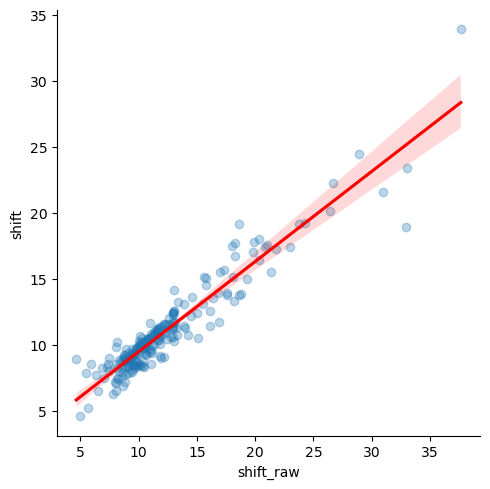

In [26]:
sns.lmplot(data=full, x="shift_raw", y="shift", line_kws={"color": "red"}, scatter_kws={"alpha": 0.3})


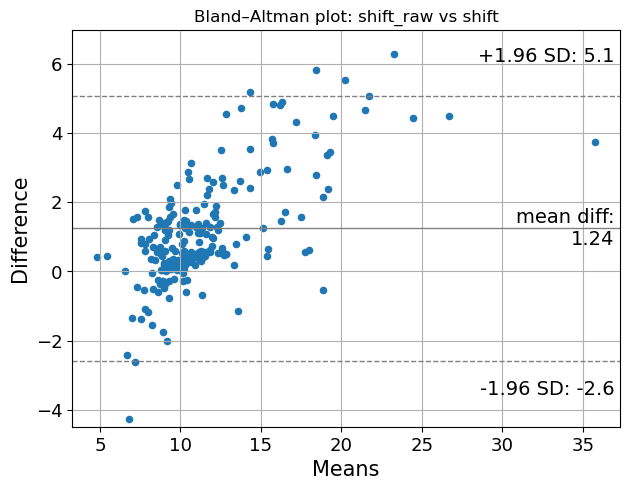

In [27]:
from statsmodels.graphics.agreement import mean_diff_plot

mean_diff_plot(full["shift_raw"], full["shift"])
plt.title("Bland–Altman plot: shift_raw vs shift")
plt.grid(True)
plt.show()
